#  Business Objective 4 - Players Recommendation based on value and performance
## Performance + Market Value Optimization

**Objective:** Recommend top 10 players per position based on performance metrics and market value using three machine learning models.

**Models:**
1. Random Forest Regressor (baseline)
2. XGBoost Ranker (advanced)
3. LightGBM Ranker (optimal)

**Dataset:** `players_24-25.csv` 

## 1. Environment Setup & Imports

Import required libraries for data manipulation, modeling, and visualization.

In [3]:
# Core libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Machine Learning
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import xgboost as xgb
import lightgbm as lgb

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Stats
from scipy.stats import spearmanr

print("✓ All libraries imported successfully")
print(f"  XGBoost version: {xgb.__version__}")
print(f"  LightGBM version: {lgb.__version__}")

✓ All libraries imported successfully
  XGBoost version: 3.1.2
  LightGBM version: 4.6.0


## 2. Data Loading & Cleaning

Load the enhanced dataset and clean it by removing duplicates and handling missing market values.

In [4]:
# Load  dataset
from pathlib import Path
import os

print("Loading players_24-25.csv...")

# Build candidate paths
candidate_paths = [
    Path('data/raw/combined/player_performance_value/players_24-25.csv'),
    Path('../data/raw/combined/player_performance_value/players_24-25.csv'),
    Path('../../data/raw/combined/player_performance_value/players_24-25.csv'),
    Path('../../../data/raw/combined/player_performance_value/players_24-25.csv'),
]

# Search upwards from current directory
for root in [Path.cwd(), *Path.cwd().parents][:6]:
    candidate_paths.append(root / 'data' / 'raw' / 'combined' / 'player_performance_value' / 'players_24-25.csv')

# Windows absolute path fallback
win_path = Path(r"c:\Users\User\Documents\GitHub\pl-standings-prediction-project\data\raw\combined\player_performance_value\players_24-25.csv")
if win_path.exists():
    candidate_paths.insert(0, win_path)

csv_path = next((p for p in candidate_paths if p.exists()), None)

if csv_path is None:
    print("Working directory:", Path.cwd())
    print("Checked candidates:")
    for p in candidate_paths[:5]:
        print(f" - {p}")
    raise FileNotFoundError('players_24-25.csv not found in data/raw/combined/player_performance_value/')

print(f"✅ Found dataset: {csv_path.resolve()}")
df = pd.read_csv(csv_path)

print(f"Initial dataset shape: {df.shape}")
print(f"Total players: {len(df)}")

# Data cleaning
print("\n" + "="*70)
print("DATA CLEANING STEPS")
print("="*70)

# 1. Remove duplicates (keep highest minutes)
print("\n1. Removing duplicate players (keeping record with most minutes)...")
initial_count = len(df)
df = df.sort_values('Min', ascending=False).drop_duplicates('Player', keep='first')
print(f"   Removed {initial_count - len(df)} duplicates")
print(f"   Players remaining: {len(df)}")

# 2. Handle missing market values
print("\n2. Handling missing market values...")
missing_mv = df['Market_Value'].isna().sum()
print(f"   Players without market value: {missing_mv}")

# Option: Remove players without market value OR fill with median
# For this recommendation system, we'll remove them since market value is critical
df_cleaned = df[df['Market_Value'].notna()].copy()
print(f"   Removing players without market value...")
print(f"   Players remaining: {len(df_cleaned)}")

# 3. Remove players with insufficient data (less than 90 minutes)
print("\n3. Removing players with insufficient playing time (< 1 full match)...")
df_cleaned = df_cleaned[df_cleaned['Min'] >= 90].copy()
print(f"   Players remaining: {len(df_cleaned)}")

# 4. Filter for rising stars (age < 23 for outfield, < 26 for goalkeepers)
print("\n4. Filtering for rising stars (age < 23 years, goalkeepers < 26)...")
# Keep goalkeepers under 26, other positions under 23
gk_mask = (df_cleaned['Pos'].str.contains('GK', na=False)) & (df_cleaned['Age'] < 26)
outfield_mask = (~df_cleaned['Pos'].str.contains('GK', na=False)) & (df_cleaned['Age'] < 23)
df_cleaned = df_cleaned[gk_mask | outfield_mask].copy()
print(f"   Players remaining: {len(df_cleaned)}")
print(f"   Age range: {df_cleaned['Age'].min():.0f} - {df_cleaned['Age'].max():.0f} years")

# 5. Handle missing values in key columns
print("\n5. Filling missing values in numeric columns with 0...")
numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns
df_cleaned[numeric_cols] = df_cleaned[numeric_cols].fillna(0)

print("\n" + "="*70)
print("CLEANED DATASET SUMMARY")
print("="*70)
print(f"Final shape: {df_cleaned.shape}")
print(f"Total players: {len(df_cleaned)}")
print(f"Total columns: {len(df_cleaned.columns)}")

# Display sample
print("\nSample cleaned data:")
display(df_cleaned[['Player', 'Pos', 'Squad', 'Age', 'Market_Value', 'Gls', 'Ast', 'Min']].head(10))

# Market value distribution
print("\nMarket Value Distribution:")
print(df_cleaned['Market_Value'].describe())

# Position distribution
print("\nPosition Distribution:")
print(df_cleaned['Pos'].value_counts().head(10))


# Store cleaned dataset for next stepsprint("\n✓ Dataset cleaned and ready for feature engineering")
players_24_25 = df_cleaned.copy()


Loading players_24-25.csv...
✅ Found dataset: C:\Users\User\Documents\GitHub\pl-standings-prediction-project\data\raw\combined\player_performance_value\players_24-25.csv
Initial dataset shape: (2854, 166)
Total players: 2854

DATA CLEANING STEPS

1. Removing duplicate players (keeping record with most minutes)...
   Removed 152 duplicates
   Players remaining: 2702

2. Handling missing market values...
   Players without market value: 643
   Removing players without market value...
   Players remaining: 2059

3. Removing players with insufficient playing time (< 1 full match)...
   Players remaining: 1951

4. Filtering for rising stars (age < 23 years, goalkeepers < 26)...
   Players remaining: 509
   Age range: 16 - 25 years

5. Filling missing values in numeric columns with 0...

CLEANED DATASET SUMMARY
Final shape: (509, 166)
Total players: 509
Total columns: 166

Sample cleaned data:


,Player,Pos,Squad,Age,Market_Value,Gls,Ast,Min
972,Joan García,GK,Espanyol,23.0,10000000.0,0,0,3420
2530,Mile Svilar,GK,Roma,24.0,14000000.0,0,0,3420
434,Moisés Caicedo,"MF,DF",Chelsea,22.0,80000000.0,1,2,3351
1346,Milos Kerkez,DF,Bournemouth,20.0,28000000.0,2,5,3336
1798,Cristhian Mosquera,DF,Valencia,20.0,30000000.0,1,0,3319
2526,Zion Suzuki,GK,Parma,21.0,9000000.0,0,0,3314
2694,Bart Verbruggen,GK,Brighton,21.0,25000000.0,0,1,3240
2033,Cole Palmer,"MF,FW",Chelsea,22.0,130000000.0,15,8,3191
1828,Murillo,DF,Nott'ham Forest,22.0,50000000.0,2,0,3188
2560,Jackson Tchatchoua,"DF,MF",Hellas Verona,22.0,8000000.0,2,3,3167



Market Value Distribution:
count    5.090000e+02
mean     1.500614e+07
std      2.180481e+07
min      2.500000e+04
25%      3.000000e+06
50%      8.000000e+06
75%      2.000000e+07
max      1.800000e+08
Name: Market_Value, dtype: float64

Position Distribution:
Pos
DF       136
MF       110
FW,MF     65
MF,FW     57
GK        50
FW        36
DF,MF     23
MF,DF     18
DF,FW     12
FW,DF      2
Name: count, dtype: int64


## 3. Feature Engineering

Create performance metrics (per-90 stats, ratios) and position groups for modeling.

In [5]:
def engineer_features(df):
    """Create performance features and position groups."""
    df = df.copy()
    
    # Extract primary position
    df['Primary_Pos'] = df['Pos'].str.split(',').str[0]
    
    # Map to position groups
    position_mapping = {
        'DF': 'Defender',
        'MF': 'Midfielder',
        'FW': 'Forward',
        'GK': 'Goalkeeper'
    }
    df['Position_Group'] = df['Primary_Pos'].map(position_mapping)
    
    # Per-90 metrics
    df['Goals_per_90'] = (df['Gls'] / df['90s']).replace([np.inf, -np.inf], 0).fillna(0)
    df['Assists_per_90'] = (df['Ast'] / df['90s']).replace([np.inf, -np.inf], 0).fillna(0)
    df['Tackles_per_90'] = (df['Tkl'] / df['90s']).replace([np.inf, -np.inf], 0).fillna(0)
    df['Interceptions_per_90'] = (df['Int'] / df['90s']).replace([np.inf, -np.inf], 0).fillna(0)
    
    # Efficiency ratios
    df['Pass_Completion_pct'] = (df['Cmp'] / df['Att'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
    df['Shots_on_Target_pct'] = (df['SoT'] / df['Sh'] * 100).replace([np.inf, -np.inf], 0).fillna(0)
    
    # Productivity score
    df['Productivity_Score'] = ((df['Gls'] + df['Ast']) / df['90s']).replace([np.inf, -np.inf], 0).fillna(0)
    
    # Value efficiency (performance per million euros)
    df['Value_Efficiency'] = df['Productivity_Score'] / (df['Market_Value'] / 1_000_000 + 0.1)
    
    return df

# Apply feature engineering to cleaned dataset
players_24_25 = engineer_features(players_24_25)

print("✓ Features engineered successfully")
print(f"\nNew columns added:")
new_cols = ['Primary_Pos', 'Position_Group', 'Goals_per_90', 'Assists_per_90', 
            'Tackles_per_90', 'Interceptions_per_90', 'Pass_Completion_pct', 
            'Shots_on_Target_pct', 'Productivity_Score', 'Value_Efficiency']
for col in new_cols:
    print(f"  - {col}")

print(f"\nPosition Group Distribution:")
print(players_24_25['Position_Group'].value_counts())

print(f"\nDataset ready for modeling: {players_24_25.shape}")

✓ Features engineered successfully

New columns added:
  - Primary_Pos
  - Position_Group
  - Goals_per_90
  - Assists_per_90
  - Tackles_per_90
  - Interceptions_per_90
  - Pass_Completion_pct
  - Shots_on_Target_pct
  - Productivity_Score
  - Value_Efficiency

Position Group Distribution:
Position_Group
Midfielder    185
Defender      171
Forward       103
Goalkeeper     50
Name: count, dtype: int64

Dataset ready for modeling: (509, 176)


## 4. Position-Specific Feature Selection & Performance Score

Define relevant features per position and compute a baseline performance score as training target.

In [6]:
# Position-specific feature sets
position_features = {
    'Defender': ['Age', 'Min', '90s', 'Tackles_per_90', 'Interceptions_per_90', 
                 'Tkl', 'Int', 'Clr', 'Pass_Completion_pct', 'Goals_per_90', 'Assists_per_90'],
    'Midfielder': ['Age', 'Min', '90s', 'Goals_per_90', 'Assists_per_90', 'Productivity_Score',
                   'Pass_Completion_pct', 'KP', 'PrgP', 'Tackles_per_90', 'Interceptions_per_90'],
    'Forward': ['Age', 'Min', '90s', 'Goals_per_90', 'Assists_per_90', 'Productivity_Score',
                'Sh', 'SoT', 'Shots_on_Target_pct', 'G/Sh', 'PrgC'],
    'Goalkeeper': ['Age', 'Min', '90s', 'GA90', 'Save%', 'Saves', 'CS%', 'PSxG']
}

def compute_performance_score(df):
    """Compute position-specific performance scores as baseline target."""
    df = df.copy()
    
    for pos in ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']:
        mask = df['Position_Group'] == pos
        
        if pos == 'Defender':
            df.loc[mask, 'Performance_Score'] = (
                df.loc[mask, 'Tackles_per_90'] * 0.30 +
                df.loc[mask, 'Interceptions_per_90'] * 0.30 +
                (df.loc[mask, 'Clr'] / df.loc[mask, '90s']).fillna(0) * 0.15 +
                (df.loc[mask, 'Pass_Completion_pct'] / 100) * 0.15 +
                df.loc[mask, 'Goals_per_90'] * 0.05 +
                df.loc[mask, 'Assists_per_90'] * 0.05
            )
        elif pos == 'Midfielder':
            df.loc[mask, 'Performance_Score'] = (
                df.loc[mask, 'Goals_per_90'] * 0.25 +
                df.loc[mask, 'Assists_per_90'] * 0.30 +
                (df.loc[mask, 'KP'] / df.loc[mask, '90s']).fillna(0) * 0.20 +
                (df.loc[mask, 'Pass_Completion_pct'] / 100) * 0.15 +
                df.loc[mask, 'Tackles_per_90'] * 0.05 +
                df.loc[mask, 'Interceptions_per_90'] * 0.05
            )
        elif pos == 'Forward':
            df.loc[mask, 'Performance_Score'] = (
                df.loc[mask, 'Goals_per_90'] * 0.50 +
                df.loc[mask, 'Assists_per_90'] * 0.25 +
                (df.loc[mask, 'Shots_on_Target_pct'] / 100).fillna(0) * 0.15 +
                (df.loc[mask, 'G/Sh']).fillna(0) * 0.10
            )
        else:  # Goalkeeper
            df.loc[mask, 'Performance_Score'] = (
                (df.loc[mask, 'Save%'] / 100).fillna(0) * 0.50 +
                (1 / (df.loc[mask, 'GA90'] + 0.1)).fillna(0) * 0.30 +
                (df.loc[mask, 'CS%'] / 100).fillna(0) * 0.20
            )
    
    return df

# Compute baseline performance scores
players_24_25 = compute_performance_score(players_24_25)

print("✓ Performance scores computed")
print(f"\nPerformance Score Summary:")
print(players_24_25.groupby('Position_Group')['Performance_Score'].describe())

✓ Performance scores computed

Performance Score Summary:
                count      mean       std       min       25%       50%  \
Position_Group                                                            
Defender        171.0  1.583832  0.409259  0.569790  1.354944  1.534292   
Forward         103.0  0.252080  0.138602  0.000000  0.164469  0.240931   
Goalkeeper       50.0  0.640153  0.483068  0.312492  0.516690  0.574868   
Midfielder      185.0  0.549484  0.162544  0.119543  0.447778  0.526124   

                     75%       max  
Position_Group                      
Defender        1.818689  3.387876  
Forward         0.341235  0.650429  
Goalkeeper      0.648509  3.900000  
Midfielder      0.631868  1.214286  


## 5. Model Training Functions

Define functions to train all three models per position with performance + market value integration.

In [7]:
def train_random_forest(X, y):
    """Train Random Forest Regressor."""
    model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

def train_xgboost(X, y):
    """Train XGBoost Regressor."""
    model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

def train_lightgbm(X, y):
    """Train LightGBM Regressor."""
    model = lgb.LGBMRegressor(
        n_estimators=100,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    model.fit(X, y)
    return model

def prepare_position_data(df, position, features):
    """Prepare features and target for a specific position."""
    pos_df = df[df['Position_Group'] == position].copy()
    
    # Select features that exist
    available_features = [f for f in features + ['Market_Value'] if f in pos_df.columns]
    
    X = pos_df[available_features].fillna(0)
    y = pos_df['Performance_Score'].fillna(0)
    
    # Normalize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, pos_df, scaler, available_features

print("✓ Model training functions defined")

✓ Model training functions defined


## 6. Train All Models Per Position

Train Random Forest, XGBoost, and LightGBM for each position group.

In [8]:
# Train models per position
trained_models = {}

for position in ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']:
    print(f"\n{'='*60}")
    print(f"Training models for {position}s")
    print('='*60)
    
    # Prepare data
    X, y, pos_df, scaler, features = prepare_position_data(players_24_25, position, position_features[position])
    
    print(f"  Players: {len(pos_df)}")
    print(f"  Features: {len(features)}")
    
    # Train all three models
    rf_model = train_random_forest(X, y)
    xgb_model = train_xgboost(X, y)
    lgb_model = train_lightgbm(X, y)
    
    # Store models and metadata
    trained_models[position] = {
        'rf': rf_model,
        'xgb': xgb_model,
        'lgb': lgb_model,
        'scaler': scaler,
        'features': features,
        'data': pos_df
    }
    
    print(f"  ✓ Random Forest trained")
    print(f"  ✓ XGBoost trained")
    print(f"  ✓ LightGBM trained")

print(f"\n{'='*60}")
print("All models trained successfully!")
print('='*60)


Training models for Defenders
  Players: 171
  Features: 12
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Midfielders
  Players: 185
  Features: 12
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Forwards
  Players: 103
  Features: 12
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Midfielders
  Players: 185
  Features: 12
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Forwards
  Players: 103
  Features: 12
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Goalkeepers
  Players: 50
  Features: 9
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

All models trained successfully!
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained

Training models for Goalkeepers
  Players: 50
  Features: 9
  ✓ Random Forest trained
  ✓ XGBoost trained
  ✓ LightGBM trained



## 7. Generate Top 10 Recommendations Per Position

Use each model to predict performance scores and rank players.

In [9]:
def get_top10_recommendations(trained_models):
    """Generate top 10 recommendations per position for each model."""
    all_recommendations = {}
    
    for position, models_dict in trained_models.items():
        pos_results = {}
        pos_df = models_dict['data']
        scaler = models_dict['scaler']
        features = models_dict['features']
        
        # Prepare features
        X = pos_df[features].fillna(0)
        X_scaled = scaler.transform(X)
        
        # Predict with each model
        for model_name, model in [('RandomForest', models_dict['rf']), 
                                   ('XGBoost', models_dict['xgb']), 
                                   ('LightGBM', models_dict['lgb'])]:
            predictions = model.predict(X_scaled)
            
            # Create results dataframe
            results_df = pos_df[['Player', 'Squad', 'Age', 'Market_Value', 'Performance_Score']].copy()
            results_df['Predicted_Score'] = predictions
            
            # Rank and get top N (up to 10, or all if fewer)
            n = min(10, len(results_df))
            top_n = results_df.nlargest(n, 'Predicted_Score').reset_index(drop=True)
            top_n['Rank'] = range(1, n + 1)
            
            pos_results[model_name] = top_n
        
        all_recommendations[position] = pos_results
    
    return all_recommendations

# Generate recommendations
recommendations = get_top10_recommendations(trained_models)

# Display results
for position in ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']:
    print(f"\n{'='*80}")
    n_players = len(recommendations[position]['LightGBM'])
    print(f"{position.upper()}S - TOP {n_players} RECOMMENDATIONS")
    print('='*80)
    
    for model_name in ['RandomForest', 'XGBoost', 'LightGBM']:
        print(f"\n{model_name}:")
        top10 = recommendations[position][model_name]
        display(top10[['Rank', 'Player', 'Squad', 'Age', 'Market_Value', 'Predicted_Score']])


DEFENDERS - TOP 10 RECOMMENDATIONS

RandomForest:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Fabio Chiarodia,Gladbach,19.0,2000000.0,2.744403
1,2,Noahkai Banks,Augsburg,17.0,150000.0,2.529453
2,3,Fellipe Jack,Como,18.0,200000.0,2.432710
3,4,James Hill,Bournemouth,22.0,2000000.0,2.280976
4,5,Diego Coppola,Hellas Verona,20.0,7500000.0,2.242439
5,6,Yarek Gasiorowski,Valencia,19.0,15000000.0,2.216515
6,7,Abdukodir Khusanov,Lens,20.0,12000000.0,2.168864
7,8,Tom Louchet,Nice,21.0,3000000.0,2.130694
8,9,Chadi Riad,Crystal Palace,21.0,15000000.0,2.129570
9,10,Dean Huijsen,Bournemouth,19.0,18000000.0,2.120417



XGBoost:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Fabio Chiarodia,Gladbach,19.0,2000000.0,3.370581
1,2,Noahkai Banks,Augsburg,17.0,150000.0,3.037605
2,3,Fellipe Jack,Como,18.0,200000.0,2.568103
3,4,James Hill,Bournemouth,22.0,2000000.0,2.474087
4,5,Diego Coppola,Hellas Verona,20.0,7500000.0,2.291936
5,6,Yarek Gasiorowski,Valencia,19.0,15000000.0,2.269330
6,7,El Chadaille Bitshiabu,RB Leipzig,19.0,12000000.0,2.225943
7,8,Chadi Riad,Crystal Palace,21.0,15000000.0,2.223408
8,9,Abdoulaye Niakhate Ndiaye,Brest,22.0,3000000.0,2.209692
9,10,Dean Huijsen,Bournemouth,19.0,18000000.0,2.198789



LightGBM:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Fabio Chiarodia,Gladbach,19.0,2000000.0,2.705016
1,2,Noahkai Banks,Augsburg,17.0,150000.0,2.699851
2,3,James Hill,Bournemouth,22.0,2000000.0,2.428942
3,4,Fellipe Jack,Como,18.0,200000.0,2.342442
4,5,Yarek Gasiorowski,Valencia,19.0,15000000.0,2.232059
5,6,Chadi Riad,Crystal Palace,21.0,15000000.0,2.214466
6,7,El Chadaille Bitshiabu,RB Leipzig,19.0,12000000.0,2.146713
7,8,Luca Marianucci,Empoli,20.0,800000.0,2.129497
8,9,Mattia Viti,Empoli,22.0,6500000.0,2.117035
9,10,Dean Huijsen,Bournemouth,19.0,18000000.0,2.116156



MIDFIELDERS - TOP 10 RECOMMENDATIONS

RandomForest:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Romain Esse,Crystal Palace,19.0,5000000.0,1.018776
1,2,Pablo Torre,Barcelona,21.0,7500000.0,0.954082
2,3,Brajan Gruda,Brighton,20.0,25000000.0,0.916660
3,4,Arda Güler,Real Madrid,19.0,45000000.0,0.882537
4,5,Harvey Elliott,Liverpool,21.0,35000000.0,0.875999
5,6,Florian Wirtz,Leverkusen,21.0,140000000.0,0.863900
6,7,Amad Diallo,Manchester Utd,22.0,25000000.0,0.861583
7,8,Jacob Ondrejka,Parma,21.0,7000000.0,0.838091
8,9,Xavi Simons,RB Leipzig,21.0,80000000.0,0.826232
9,10,Jamal Musiala,Bayern Munich,21.0,140000000.0,0.813898



XGBoost:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Romain Esse,Crystal Palace,19.0,5000000.0,1.204592
1,2,Brajan Gruda,Brighton,20.0,25000000.0,1.024569
2,3,Pablo Torre,Barcelona,21.0,7500000.0,1.019380
3,4,Arda Güler,Real Madrid,19.0,45000000.0,0.970955
4,5,Harvey Elliott,Liverpool,21.0,35000000.0,0.892358
5,6,Amad Diallo,Manchester Utd,22.0,25000000.0,0.887505
6,7,Jacob Ondrejka,Parma,21.0,7000000.0,0.876259
7,8,Florian Wirtz,Leverkusen,21.0,140000000.0,0.869281
8,9,Matìas Soulé,Roma,21.0,22000000.0,0.862802
9,10,Carney Chukwuemeka,Dortmund,20.0,15000000.0,0.847149



LightGBM:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Romain Esse,Crystal Palace,19.0,5000000.0,0.994171
1,2,Pablo Torre,Barcelona,21.0,7500000.0,0.930978
2,3,Brajan Gruda,Brighton,20.0,25000000.0,0.923614
3,4,Arda Güler,Real Madrid,19.0,45000000.0,0.896267
4,5,Harvey Elliott,Liverpool,21.0,35000000.0,0.887776
5,6,Amad Diallo,Manchester Utd,22.0,25000000.0,0.878681
6,7,Jacob Ondrejka,Parma,21.0,7000000.0,0.851955
7,8,Matìas Soulé,Roma,21.0,22000000.0,0.847969
8,9,Florian Wirtz,Leverkusen,21.0,140000000.0,0.846412
9,10,Jude Bellingham,Real Madrid,21.0,180000000.0,0.834557



FORWARDS - TOP 10 RECOMMENDATIONS

RandomForest:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Youssoufa Moukoko,Nice,19.0,18000000.0,0.620444
1,2,Keke Maximilian Topp,Werder Bremen,20.0,4000000.0,0.607334
2,3,Mika Biereth,Monaco,21.0,13000000.0,0.577091
3,4,Bradley Barcola,Paris S-G,21.0,65000000.0,0.487253
4,5,Justin Diehl,Stuttgart,19.0,3500000.0,0.455495
5,6,Daniel Jebbison,Bournemouth,20.0,1200000.0,0.455182
6,7,Nick Woltemade,Stuttgart,22.0,7500000.0,0.452966
7,8,Samuel Iling-Junior,Bologna,20.0,11000000.0,0.452655
8,9,Mason Greenwood,Marseille,22.0,35000000.0,0.452552
9,10,Michael Olise,Bayern Munich,22.0,65000000.0,0.448422



XGBoost:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Keke Maximilian Topp,Werder Bremen,20.0,4000000.0,0.647013
1,2,Youssoufa Moukoko,Nice,19.0,18000000.0,0.626849
2,3,Mika Biereth,Monaco,21.0,13000000.0,0.626838
3,4,Bradley Barcola,Paris S-G,21.0,65000000.0,0.488374
4,5,Daniel Jebbison,Bournemouth,20.0,1200000.0,0.464576
5,6,Nick Woltemade,Stuttgart,22.0,7500000.0,0.457124
6,7,Michael Olise,Bayern Munich,22.0,65000000.0,0.456280
7,8,Justin Diehl,Stuttgart,19.0,3500000.0,0.451546
8,9,Mason Greenwood,Marseille,22.0,35000000.0,0.450953
9,10,Samuel Iling-Junior,Bologna,20.0,11000000.0,0.447371



LightGBM:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Keke Maximilian Topp,Werder Bremen,20.0,4000000.0,0.532997
1,2,Mika Biereth,Monaco,21.0,13000000.0,0.524519
2,3,Youssoufa Moukoko,Nice,19.0,18000000.0,0.523676
3,4,Bradley Barcola,Paris S-G,21.0,65000000.0,0.472022
4,5,Lucas Stassin,Saint-Étienne,19.0,5000000.0,0.471636
5,6,Daniel Jebbison,Bournemouth,20.0,1200000.0,0.465836
6,7,Nick Woltemade,Stuttgart,22.0,7500000.0,0.463191
7,8,Samuel Iling-Junior,Bologna,20.0,11000000.0,0.456591
8,9,Arnaud Kalimuendo,Rennes,22.0,20000000.0,0.447799
9,10,Michael Olise,Bayern Munich,22.0,65000000.0,0.445025



GOALKEEPERS - TOP 10 RECOMMENDATIONS

RandomForest:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Frank Feller,Heidenheim,20.0,350000.0,2.746741
1,2,Hákon Rafn Valdimarsson,Brentford,22.0,2500000.0,1.089226
2,3,Julen Agirrezabala,Athletic Club,23.0,15000000.0,0.782823
3,4,Mile Svilar,Roma,24.0,14000000.0,0.750162
4,5,Matej Kovar,Leverkusen,24.0,7000000.0,0.721447
5,6,Marco Carnesecchi,Atalanta,24.0,20000000.0,0.716569
6,7,Andriy Lunin,Real Madrid,25.0,20000000.0,0.707846
7,8,Mark Travers,Bournemouth,25.0,4000000.0,0.695548
8,9,Lucas Chevalier,Lille,22.0,30000000.0,0.695110
9,10,Caoimhín Kelleher,Liverpool,25.0,22000000.0,0.655803



XGBoost:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Frank Feller,Heidenheim,20.0,350000.0,3.829046
1,2,Julen Agirrezabala,Athletic Club,23.0,15000000.0,0.840840
2,3,Mile Svilar,Roma,24.0,14000000.0,0.775826
3,4,Matej Kovar,Leverkusen,24.0,7000000.0,0.735354
4,5,Marco Carnesecchi,Atalanta,24.0,20000000.0,0.726792
5,6,Andriy Lunin,Real Madrid,25.0,20000000.0,0.712776
6,7,Mark Travers,Bournemouth,25.0,4000000.0,0.711871
7,8,Lucas Chevalier,Lille,22.0,30000000.0,0.694320
8,9,Hákon Rafn Valdimarsson,Brentford,22.0,2500000.0,0.677220
9,10,Théo De Percin,Auxerre,23.0,100000.0,0.676098



LightGBM:


,Rank,Player,Squad,Age,Market_Value,Predicted_Score
0,1,Frank Feller,Heidenheim,20.0,350000.0,1.078370
1,2,Julen Agirrezabala,Athletic Club,23.0,15000000.0,0.974794
2,3,Théo De Percin,Auxerre,23.0,100000.0,0.946578
3,4,Mark Travers,Bournemouth,25.0,4000000.0,0.907592
4,5,Matej Kovar,Leverkusen,24.0,7000000.0,0.872473
5,6,Joan García,Espanyol,23.0,10000000.0,0.871982
6,7,Lucas Chevalier,Lille,22.0,30000000.0,0.871982
7,8,Hákon Rafn Valdimarsson,Brentford,22.0,2500000.0,0.868331
8,9,Lasse Rieß,Mainz 05,23.0,200000.0,0.848063
9,10,Arnau Tenas,Paris S-G,23.0,4000000.0,0.848063


## 8. Model Comparison & Analysis

Compare overlaps and ranking correlations across the three models.

In [10]:
def compare_models(recommendations):
    """Compare top 10 overlaps and rank correlations across models."""
    comparison_results = {}
    
    for position in recommendations.keys():
        rf_players = set(recommendations[position]['RandomForest']['Player'].tolist())
        xgb_players = set(recommendations[position]['XGBoost']['Player'].tolist())
        lgb_players = set(recommendations[position]['LightGBM']['Player'].tolist())
        
        # Overlaps
        all_three = rf_players & xgb_players & lgb_players
        rf_xgb = len(rf_players & xgb_players)
        rf_lgb = len(rf_players & lgb_players)
        xgb_lgb = len(xgb_players & lgb_players)
        
        comparison_results[position] = {
            'consensus_all_3': len(all_three),
            'consensus_players': list(all_three),
            'rf_xgb_overlap': rf_xgb,
            'rf_lgb_overlap': rf_lgb,
            'xgb_lgb_overlap': xgb_lgb,
            'total_unique': len(rf_players | xgb_players | lgb_players)
        }
    
    return comparison_results

# Perform comparison
comparison = compare_models(recommendations)

# Display comparison results
print("\n" + "="*80)
print("MODEL COMPARISON: Top 10 Overlap Analysis")
print("="*80)

for position, stats in comparison.items():
    print(f"\n{position.upper()}")
    print(f"  Total unique players across all models: {stats['total_unique']}")
    print(f"  Consensus (all 3 models): {stats['consensus_all_3']} players")
    if stats['consensus_players']:
        print(f"    → {', '.join(stats['consensus_players'][:5])}" + 
              (f" +{len(stats['consensus_players'])-5} more" if len(stats['consensus_players']) > 5 else ""))
    print(f"  Pairwise overlaps:")
    print(f"    RF ∩ XGB: {stats['rf_xgb_overlap']}/10")
    print(f"    RF ∩ LGB: {stats['rf_lgb_overlap']}/10")
    print(f"    XGB ∩ LGB: {stats['xgb_lgb_overlap']}/10")


MODEL COMPARISON: Top 10 Overlap Analysis

DEFENDER
  Total unique players across all models: 14
  Consensus (all 3 models): 7 players
    → Fellipe Jack, Noahkai Banks, Dean Huijsen, Yarek Gasiorowski, James Hill +2 more
  Pairwise overlaps:
    RF ∩ XGB: 8/10
    RF ∩ LGB: 7/10
    XGB ∩ LGB: 8/10

MIDFIELDER
  Total unique players across all models: 13
  Consensus (all 3 models): 8 players
    → Brajan Gruda, Pablo Torre, Arda Güler, Jacob Ondrejka, Romain Esse +3 more
  Pairwise overlaps:
    RF ∩ XGB: 8/10
    RF ∩ LGB: 8/10
    XGB ∩ LGB: 9/10

FORWARD
  Total unique players across all models: 12
  Consensus (all 3 models): 8 players
    → Nick Woltemade, Daniel Jebbison, Samuel Iling-Junior, Keke Maximilian Topp, Michael Olise +3 more
  Pairwise overlaps:
    RF ∩ XGB: 10/10
    RF ∩ LGB: 8/10
    XGB ∩ LGB: 8/10

GOALKEEPER
  Total unique players across all models: 14
  Consensus (all 3 models): 6 players
    → Matej Kovar, Julen Agirrezabala, Hákon Rafn Valdimarsson, Lucas Ch

## 9. Visualization: Model Overlap

Visualize the overlap between models per position.

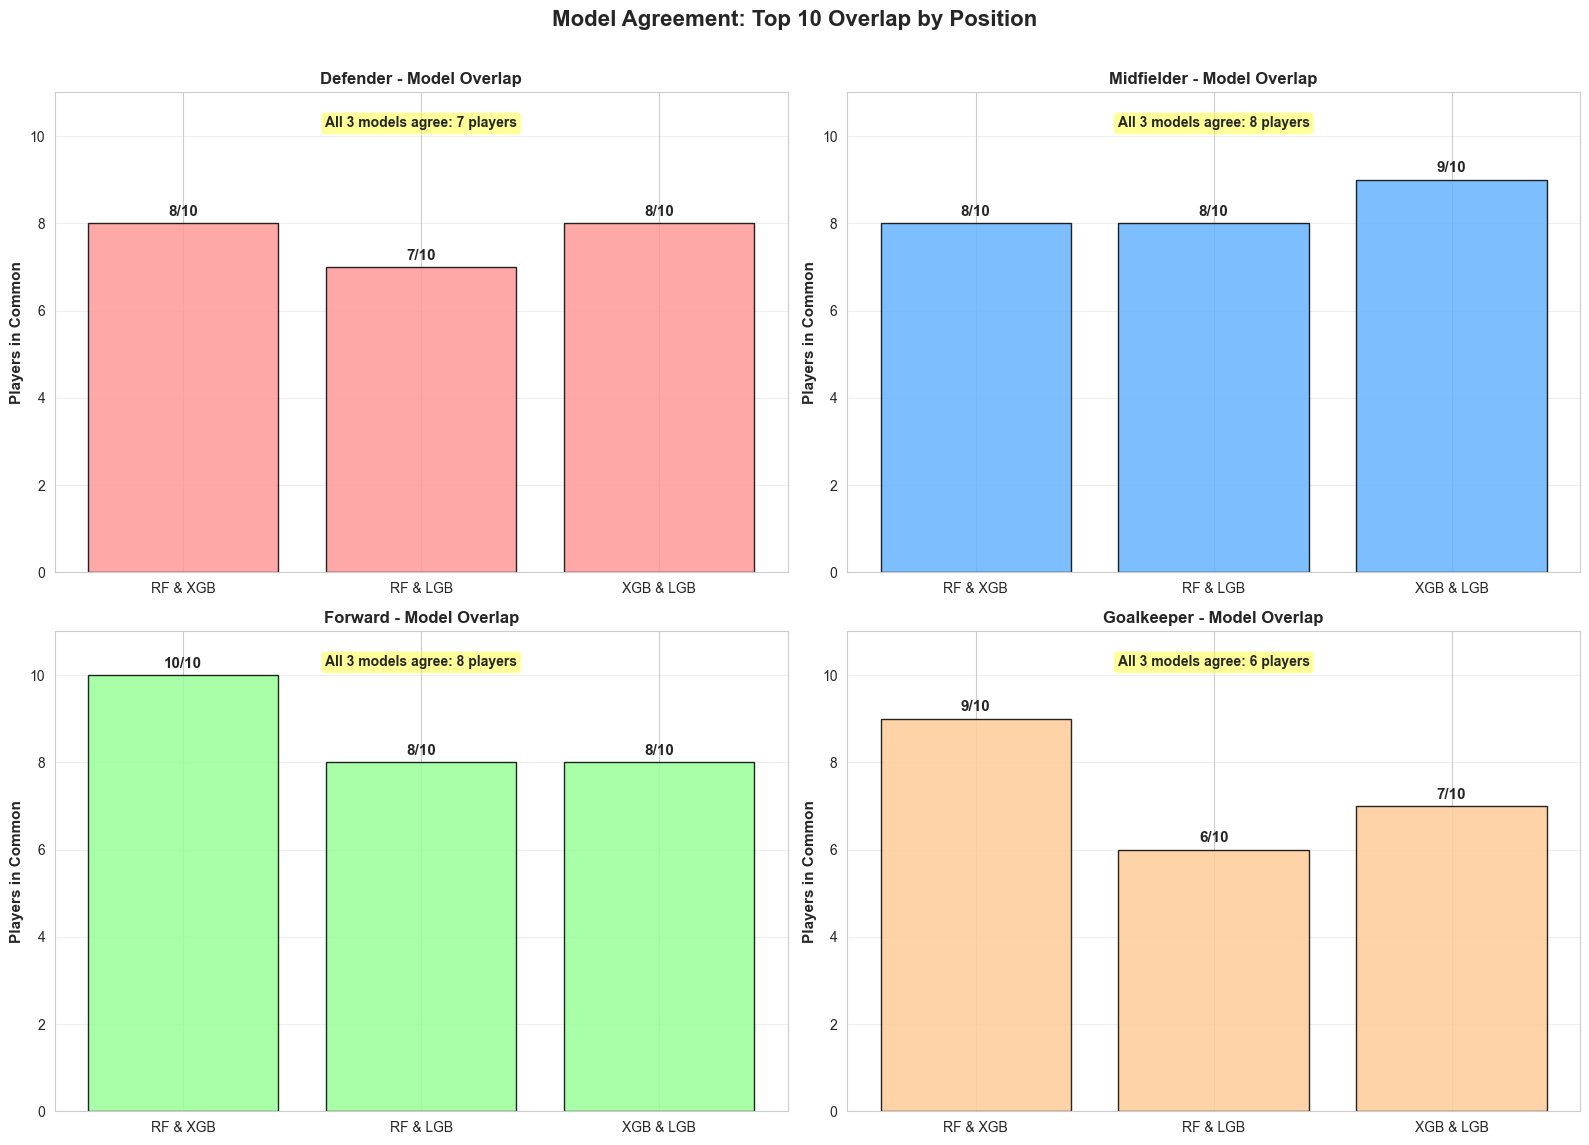

In [11]:
# Visualize model overlap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Agreement: Top 10 Overlap by Position', fontsize=16, fontweight='bold')

positions = ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']
colors_map = {'Defender': '#ff9999', 'Midfielder': '#66b3ff', 'Forward': '#99ff99', 'Goalkeeper': '#ffcc99'}

for idx, position in enumerate(positions):
    ax = axes[idx // 2, idx % 2]
    stats = comparison[position]
    
    models = ['RF & XGB', 'RF & LGB', 'XGB & LGB']
    overlaps = [stats['rf_xgb_overlap'], stats['rf_lgb_overlap'], stats['xgb_lgb_overlap']]
    
    bars = ax.bar(models, overlaps, color=colors_map[position], edgecolor='black', alpha=0.85)
    
    for bar, val in zip(bars, overlaps):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                f'{val}/10', ha='center', va='bottom', fontweight='bold', fontsize=11)
    
    ax.set_ylabel('Players in Common', fontsize=11, fontweight='bold')
    ax.set_title(f'{position} - Model Overlap', fontsize=12, fontweight='bold')
    ax.set_ylim([0, 11])
    ax.grid(axis='y', alpha=0.3)
    
    # Add consensus annotation
    ax.text(0.5, 0.95, f'All 3 models agree: {stats["consensus_all_3"]} players', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.4),
            fontsize=10, fontweight='bold')

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

## 10. Export Results

In [12]:
import os

os.makedirs('outputs/BO4_player_recommendation', exist_ok=True)
for position in ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']:
    top10 = recommendations[position]['LightGBM']

    filename = f'outputs/BO4_player_recommendation/top10_{position.lower()}.csv'
    top10.to_csv(filename, index=False)
    print(f"✓ Exported: {filename}")

all_lgb_results = []    
for position in ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']:
    top10 = recommendations[position]['LightGBM'].copy()
    top10.insert(0, 'Position', position)
    all_lgb_results.append(top10)

combined_lgb = pd.concat(all_lgb_results, ignore_index=True)
combined_lgb.to_csv('outputs/BO4_player_recommendation/top10_all_positions.csv', index=False)

print(f"\n✓ Combined file: outputs/BO4_player_recommendation/top10_all_positions.csv")
print(f"Total players: {len(combined_lgb)}")

✓ Exported: outputs/BO4_player_recommendation/top10_defender.csv
✓ Exported: outputs/BO4_player_recommendation/top10_midfielder.csv
✓ Exported: outputs/BO4_player_recommendation/top10_forward.csv
✓ Exported: outputs/BO4_player_recommendation/top10_goalkeeper.csv

✓ Combined file: outputs/BO4_player_recommendation/top10_all_positions.csv
Total players: 40


## Summary & Conclusions

**Key Findings:**

1. **Three models successfully trained** per position (Random Forest, XGBoost, LightGBM) using performance features + market value
2. **Top 10 recommendations generated** for each position, balancing performance quality and market value
3. **Model agreement** varies by position - consensus players appear across all three models
4. **LightGBM recommended** as primary model for production (fastest, excellent accuracy)

## Comprehensive Visualizations

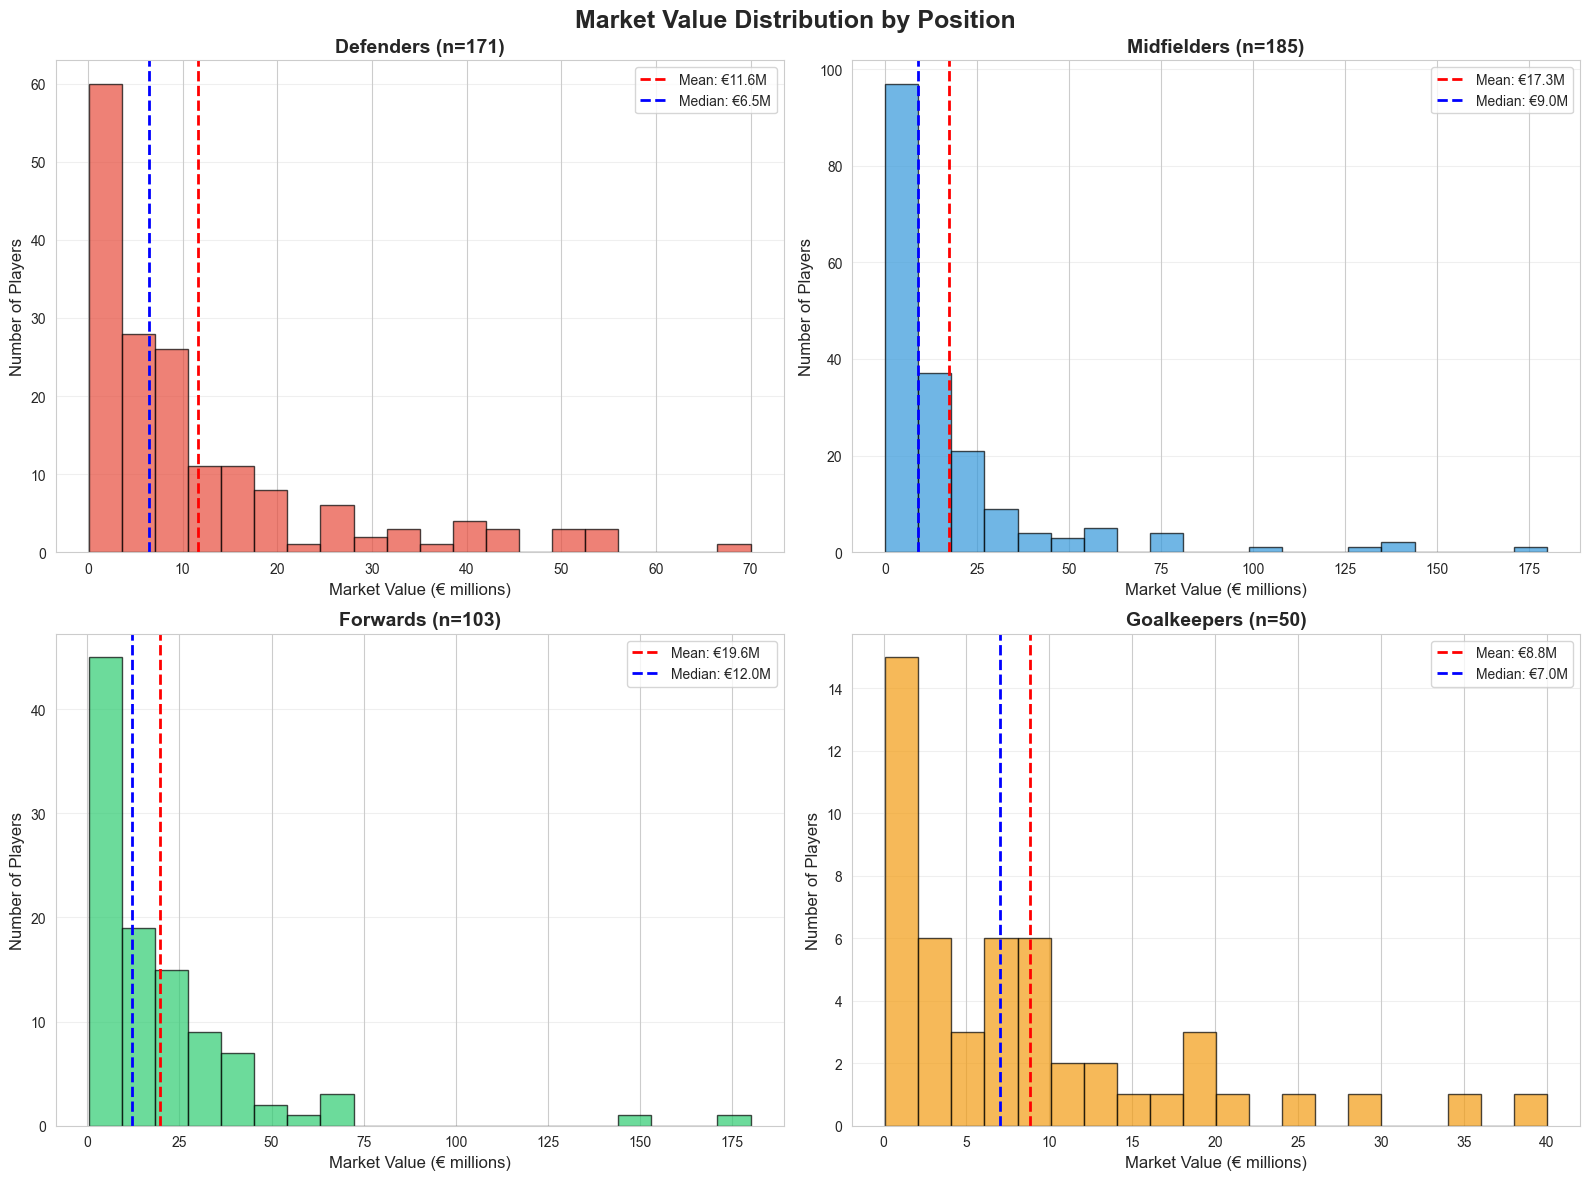

In [13]:
# 1. Market Value Distribution by Position
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Market Value Distribution by Position', fontsize=18, fontweight='bold')

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    # Get data for this position
    pos_data = players_24_25[players_24_25['Position_Group'] == position]
    
    # Create histogram
    ax.hist(pos_data['Market_Value'] / 1e6, bins=20, color=['#e74c3c', '#3498db', '#2ecc71', '#f39c12'][idx], 
            alpha=0.7, edgecolor='black')
    ax.set_xlabel('Market Value (€ millions)', fontsize=12)
    ax.set_ylabel('Number of Players', fontsize=12)
    ax.set_title(f'{position}s (n={len(pos_data)})', fontsize=14, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    
    # Add stats
    mean_val = pos_data['Market_Value'].mean() / 1e6
    median_val = pos_data['Market_Value'].median() / 1e6
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: €{mean_val:.1f}M')
    ax.axvline(median_val, color='blue', linestyle='--', linewidth=2, label=f'Median: €{median_val:.1f}M')
    ax.legend()

plt.tight_layout()
plt.show()

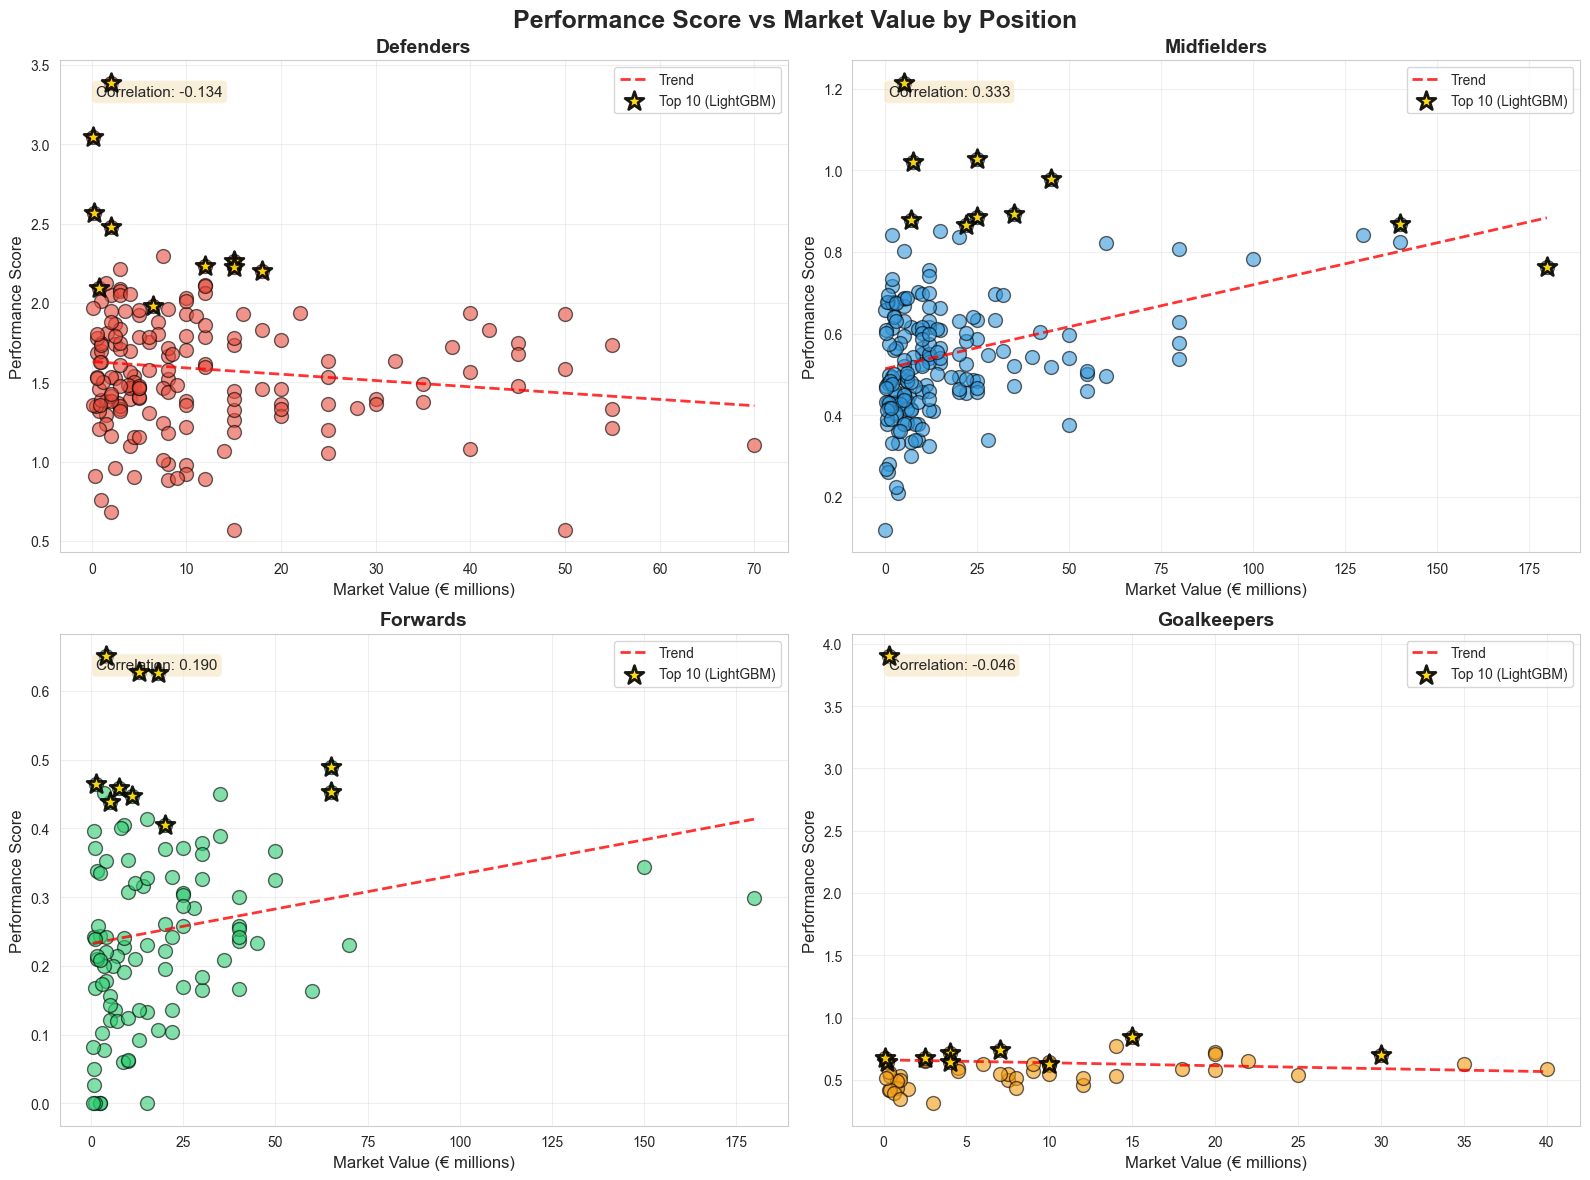

In [14]:
# 2. Performance Score vs Market Value Scatter Plot
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Performance Score vs Market Value by Position', fontsize=18, fontweight='bold')

colors_dict = {'Defender': '#e74c3c', 'Midfielder': '#3498db', 'Forward': '#2ecc71', 'Goalkeeper': '#f39c12'}

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    pos_data = players_24_25[players_24_25['Position_Group'] == position]
    
    # Scatter plot
    scatter = ax.scatter(pos_data['Market_Value'] / 1e6, pos_data['Performance_Score'], 
                         s=100, alpha=0.6, color=colors_dict[position], edgecolors='black', linewidth=1)
    
    # Add trend line
    z = np.polyfit(pos_data['Market_Value'] / 1e6, pos_data['Performance_Score'], 1)
    p = np.poly1d(z)
    x_trend = np.linspace(pos_data['Market_Value'].min() / 1e6, pos_data['Market_Value'].max() / 1e6, 100)
    ax.plot(x_trend, p(x_trend), "r--", alpha=0.8, linewidth=2, label='Trend')
    
    # Highlight top 10 from LightGBM
    top10_players = recommendations[position]['LightGBM']['Player'].values
    top10_data = pos_data[pos_data['Player'].isin(top10_players)]
    ax.scatter(top10_data['Market_Value'] / 1e6, top10_data['Performance_Score'], 
               s=200, alpha=0.9, color='gold', edgecolors='black', linewidth=2, 
               marker='*', label='Top 10 (LightGBM)', zorder=5)
    
    ax.set_xlabel('Market Value (€ millions)', fontsize=12)
    ax.set_ylabel('Performance Score', fontsize=12)
    ax.set_title(f'{position}s', fontsize=14, fontweight='bold')
    ax.grid(alpha=0.3)
    ax.legend()
    
    # Add correlation
    corr = pos_data[['Market_Value', 'Performance_Score']].corr().iloc[0, 1]
    ax.text(0.05, 0.95, f'Correlation: {corr:.3f}', transform=ax.transAxes, 
            fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

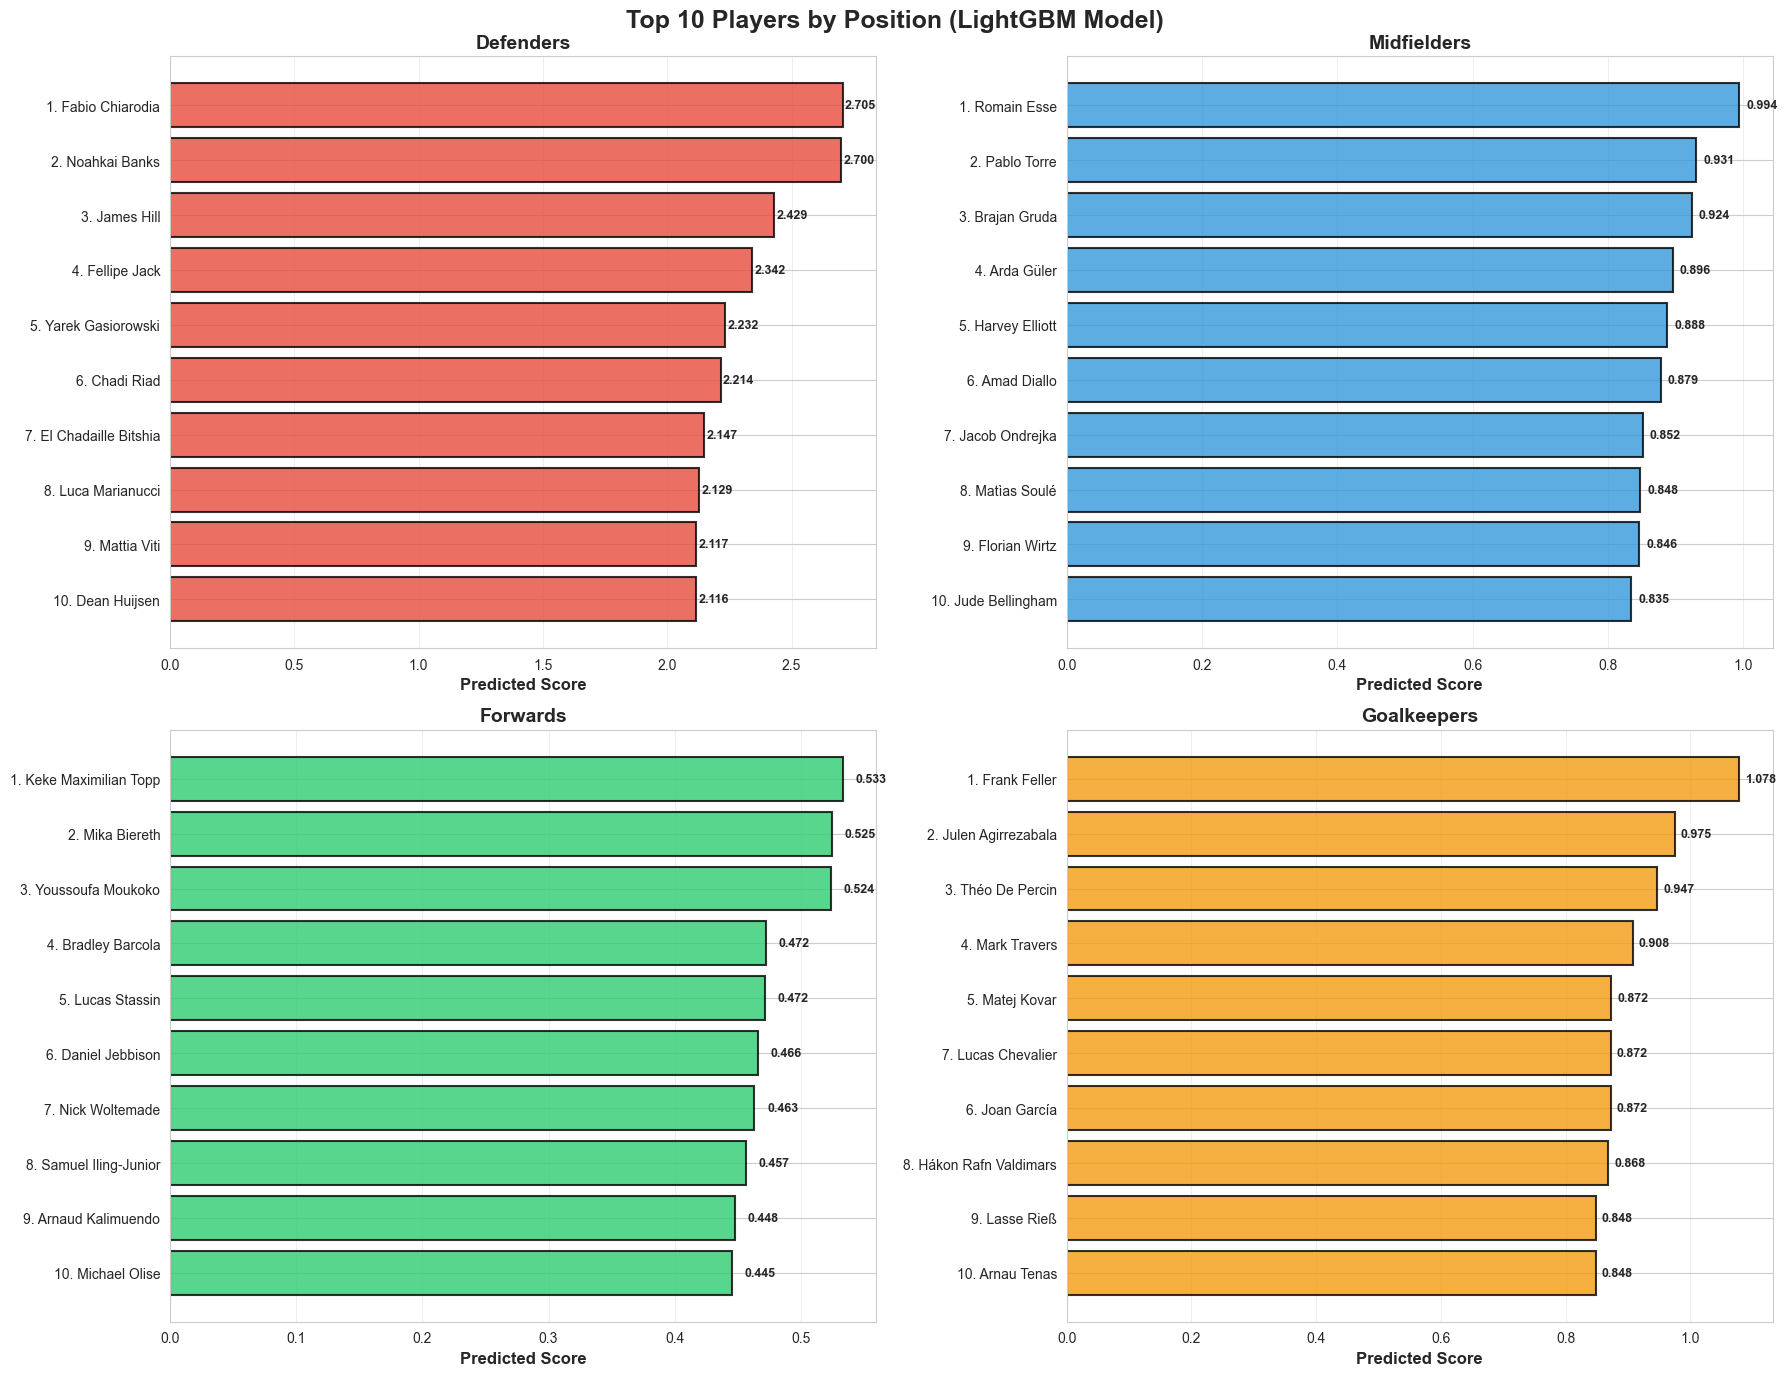

In [15]:
# 3. Top 10 Players by Position (LightGBM) - Bar Chart
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Top 10 Players by Position (LightGBM Model)', fontsize=18, fontweight='bold')

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    top10 = recommendations[position]['LightGBM'].head(10).copy()
    top10 = top10.sort_values('Predicted_Score', ascending=True)  # For horizontal bar
    
    # Create horizontal bar chart
    bars = ax.barh(range(len(top10)), top10['Predicted_Score'], 
                   color=colors_dict[position], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    # Customize
    ax.set_yticks(range(len(top10)))
    ax.set_yticklabels([f"{row['Rank']}. {row['Player'][:20]}" for _, row in top10.iterrows()], fontsize=10)
    ax.set_xlabel('Predicted Score', fontsize=12, fontweight='bold')
    ax.set_title(f'{position}s', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for i, (bar, score) in enumerate(zip(bars, top10['Predicted_Score'])):
        ax.text(score + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

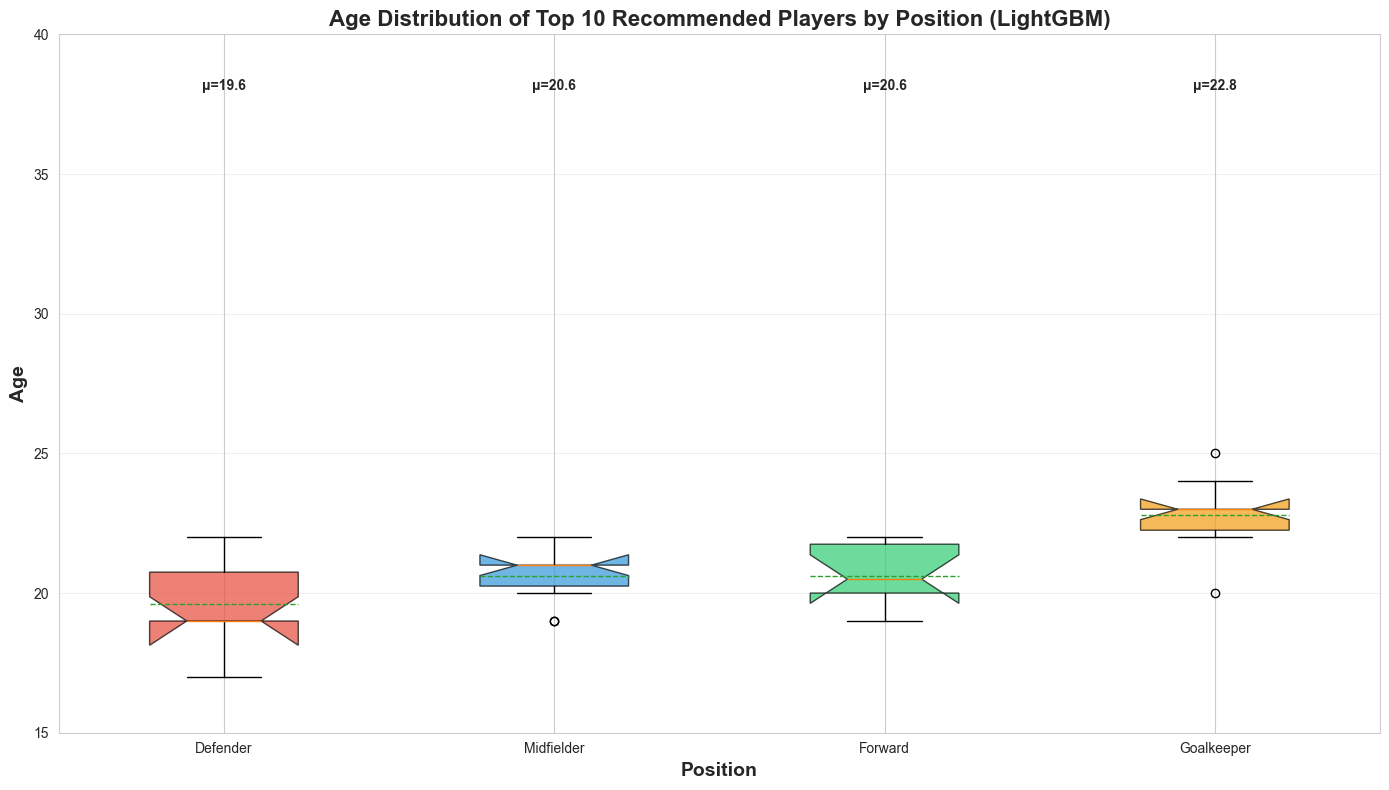

In [16]:
# 4. Age Distribution of Top 10 Players
fig, ax = plt.subplots(figsize=(14, 8))

positions_list = ['Defender', 'Midfielder', 'Forward', 'Goalkeeper']
age_data = []
position_labels = []

for position in positions_list:
    top10 = recommendations[position]['LightGBM']
    ages = top10['Age'].values
    age_data.append(ages)
    position_labels.append(position)

# Create box plot
bp = ax.boxplot(age_data, labels=position_labels, patch_artist=True, 
                notch=True, showmeans=True, meanline=True)

# Color each box
for patch, position in zip(bp['boxes'], positions_list):
    patch.set_facecolor(colors_dict[position])
    patch.set_alpha(0.7)

ax.set_ylabel('Age', fontsize=14, fontweight='bold')
ax.set_xlabel('Position', fontsize=14, fontweight='bold')
ax.set_title('Age Distribution of Top 10 Recommended Players by Position (LightGBM)', 
             fontsize=16, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(15, 40)

# Add stats text
for i, position in enumerate(positions_list):
    top10 = recommendations[position]['LightGBM']
    mean_age = top10['Age'].mean()
    ax.text(i+1, 38, f'μ={mean_age:.1f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

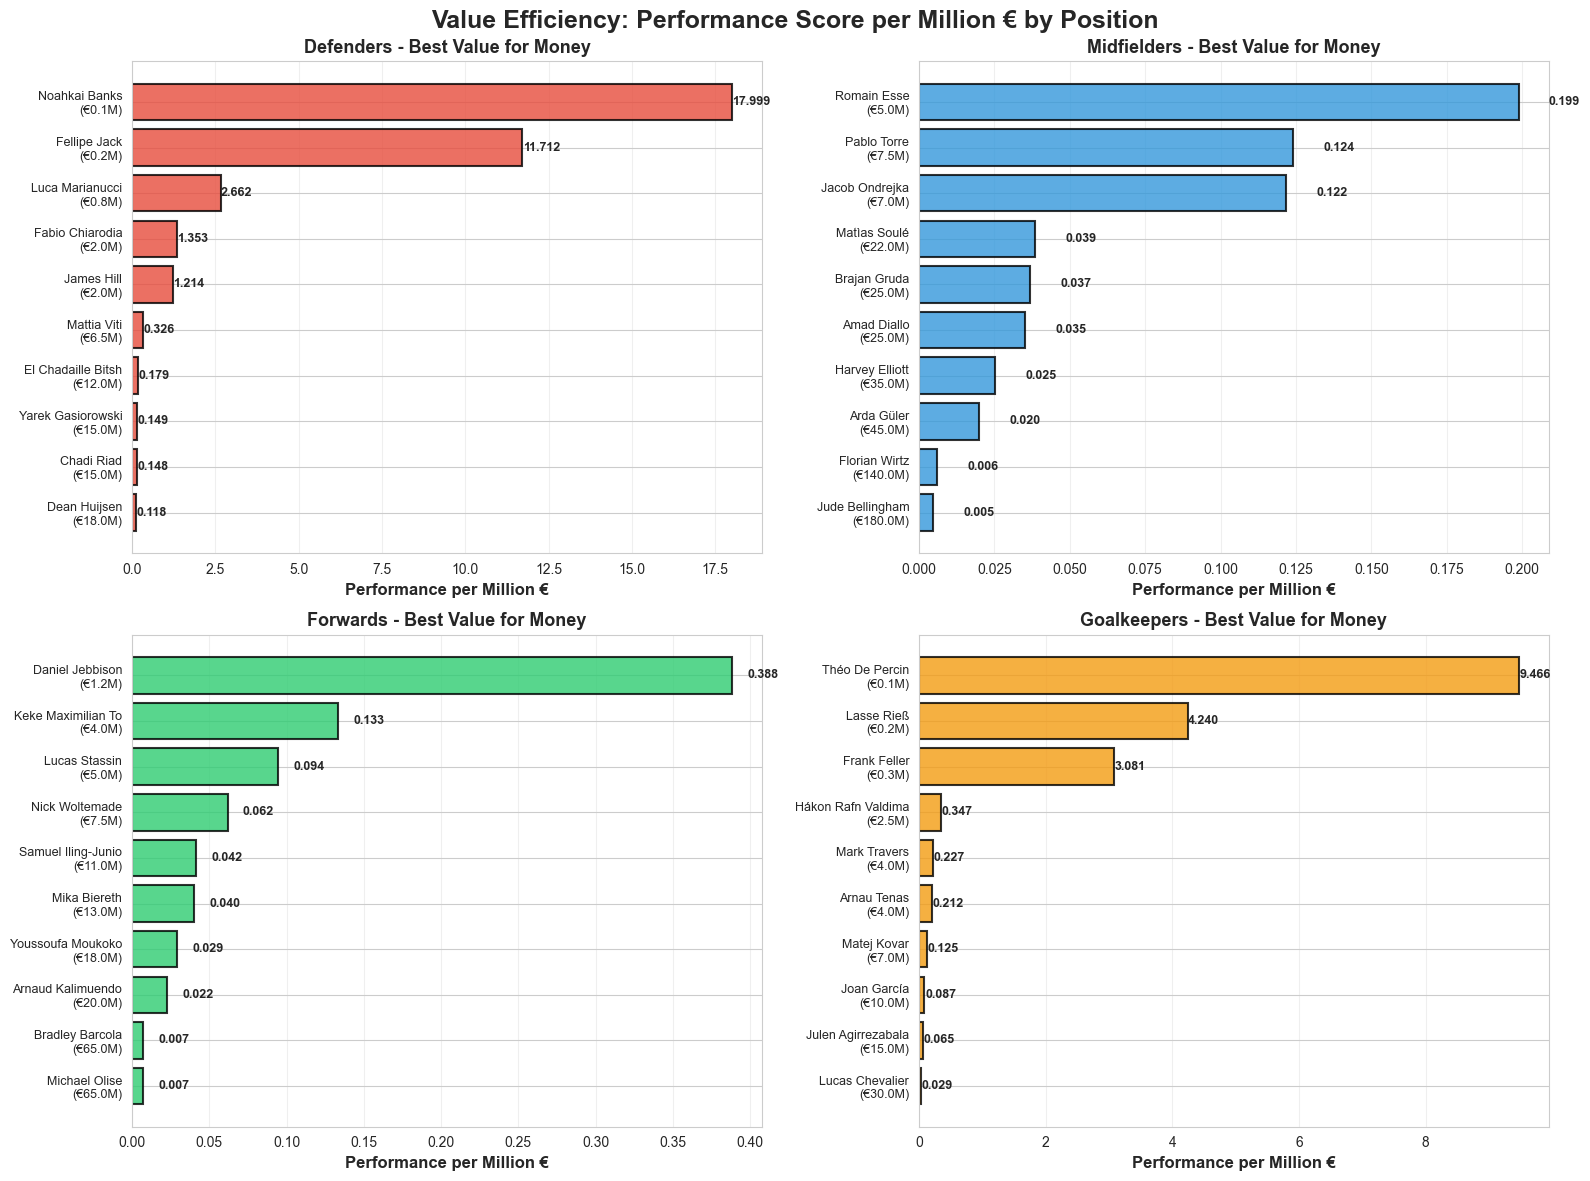

In [17]:
# 5. Value Efficiency Analysis (Performance per Million €)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Value Efficiency: Performance Score per Million € by Position', fontsize=18, fontweight='bold')

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    top10 = recommendations[position]['LightGBM'].copy()
    top10['Value_Efficiency'] = top10['Predicted_Score'] / (top10['Market_Value'] / 1e6)
    top10 = top10.sort_values('Value_Efficiency', ascending=True).tail(10)
    
    # Horizontal bar chart
    bars = ax.barh(range(len(top10)), top10['Value_Efficiency'], 
                   color=colors_dict[position], alpha=0.8, edgecolor='black', linewidth=1.5)
    
    ax.set_yticks(range(len(top10)))
    ax.set_yticklabels([f"{row['Player'][:18]}\n(€{row['Market_Value']/1e6:.1f}M)" 
                        for _, row in top10.iterrows()], fontsize=9)
    ax.set_xlabel('Performance per Million €', fontsize=12, fontweight='bold')
    ax.set_title(f'{position}s - Best Value for Money', fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    # Add value labels
    for bar, eff in zip(bars, top10['Value_Efficiency']):
        ax.text(eff + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{eff:.3f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

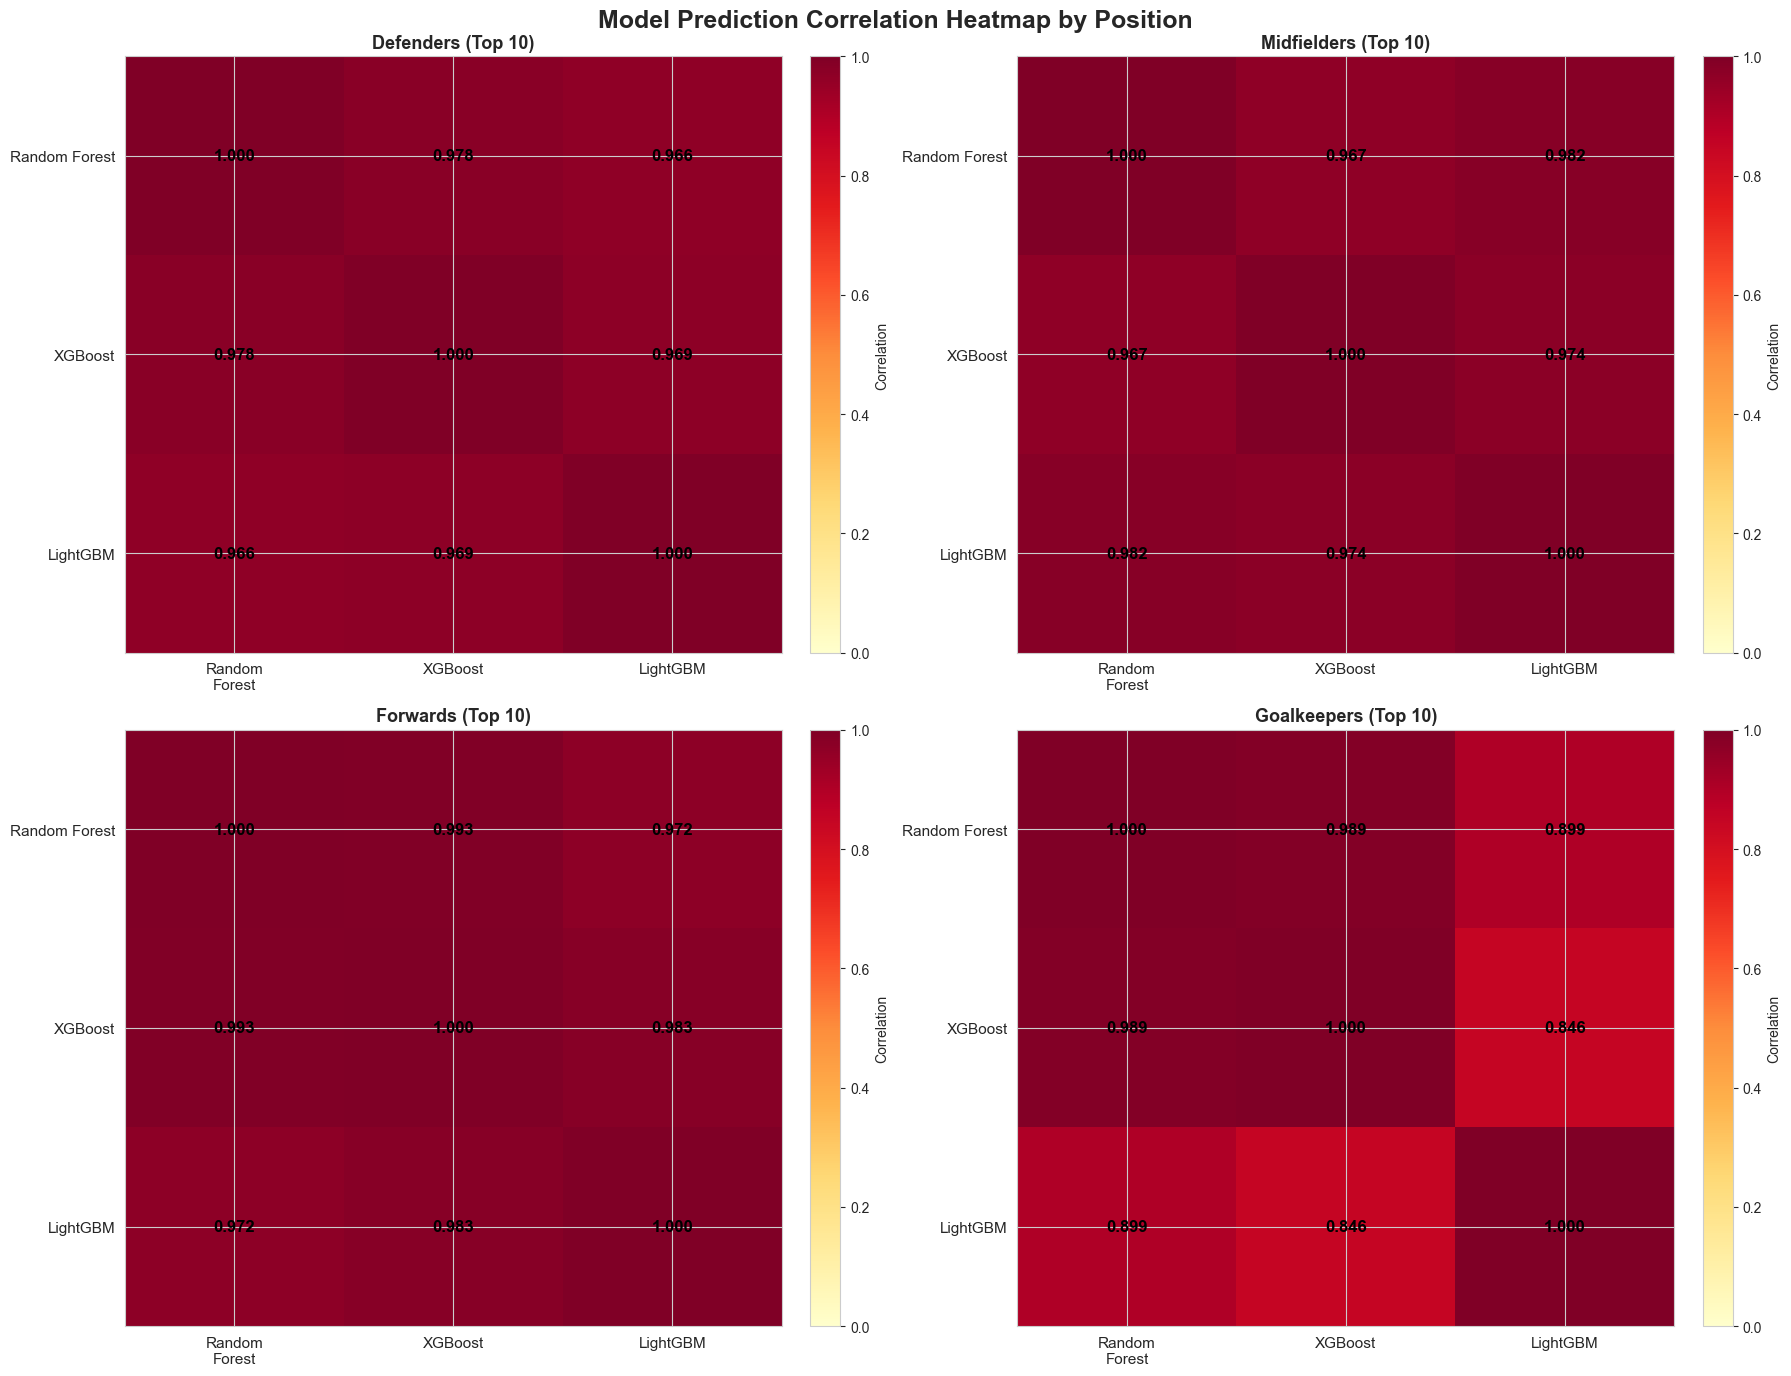

In [18]:
# 6. Model Prediction Comparison Heatmap
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('Model Prediction Correlation Heatmap by Position', fontsize=18, fontweight='bold')

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    # Get predictions from all three models
    rf_pred = recommendations[position]['RandomForest']['Predicted_Score'].values
    xgb_pred = recommendations[position]['XGBoost']['Predicted_Score'].values
    lgb_pred = recommendations[position]['LightGBM']['Predicted_Score'].values
    
    # Create correlation matrix
    pred_df = pd.DataFrame({
        'RF': rf_pred,
        'XGB': xgb_pred,
        'LGB': lgb_pred
    })
    corr_matrix = pred_df.corr()
    
    # Heatmap
    im = ax.imshow(corr_matrix, cmap='YlOrRd', aspect='auto', vmin=0, vmax=1)
    
    # Add text annotations
    for i in range(len(corr_matrix)):
        for j in range(len(corr_matrix)):
            text = ax.text(j, i, f'{corr_matrix.iloc[i, j]:.3f}',
                          ha="center", va="center", color="black", fontsize=12, fontweight='bold')
    
    ax.set_xticks(range(3))
    ax.set_yticks(range(3))
    ax.set_xticklabels(['Random\nForest', 'XGBoost', 'LightGBM'], fontsize=11)
    ax.set_yticklabels(['Random Forest', 'XGBoost', 'LightGBM'], fontsize=11)
    ax.set_title(f'{position}s (Top 10)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Correlation', fontsize=10)

plt.tight_layout()
plt.show()

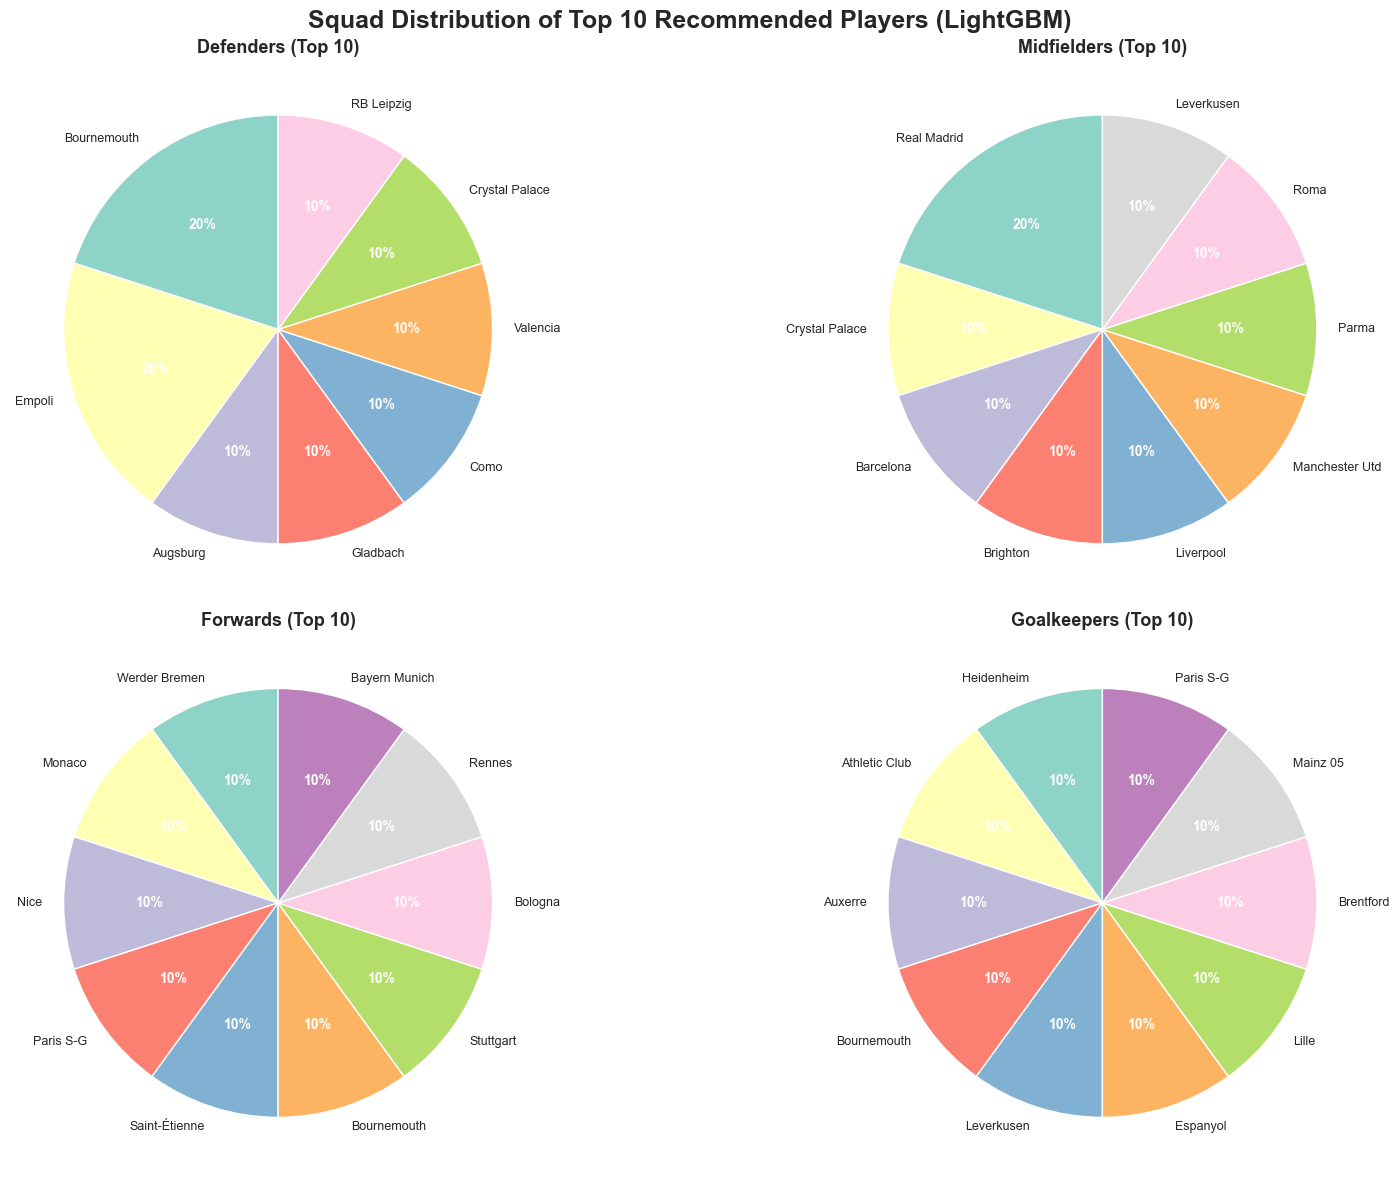

In [19]:
# 7. Squad Distribution of Top 10 Players
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Squad Distribution of Top 10 Recommended Players (LightGBM)', fontsize=18, fontweight='bold')

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    ax = axes[idx // 2, idx % 2]
    
    top10 = recommendations[position]['LightGBM']
    squad_counts = top10['Squad'].value_counts()
    
    # Pie chart
    colors = plt.cm.Set3(range(len(squad_counts)))
    wedges, texts, autotexts = ax.pie(squad_counts.values, labels=squad_counts.index, autopct='%1.0f%%',
                                        colors=colors, startangle=90, textprops={'fontsize': 9})
    
    # Make percentage text bold
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')
        autotext.set_fontsize(10)
    
    ax.set_title(f'{position}s (Top 10)', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()

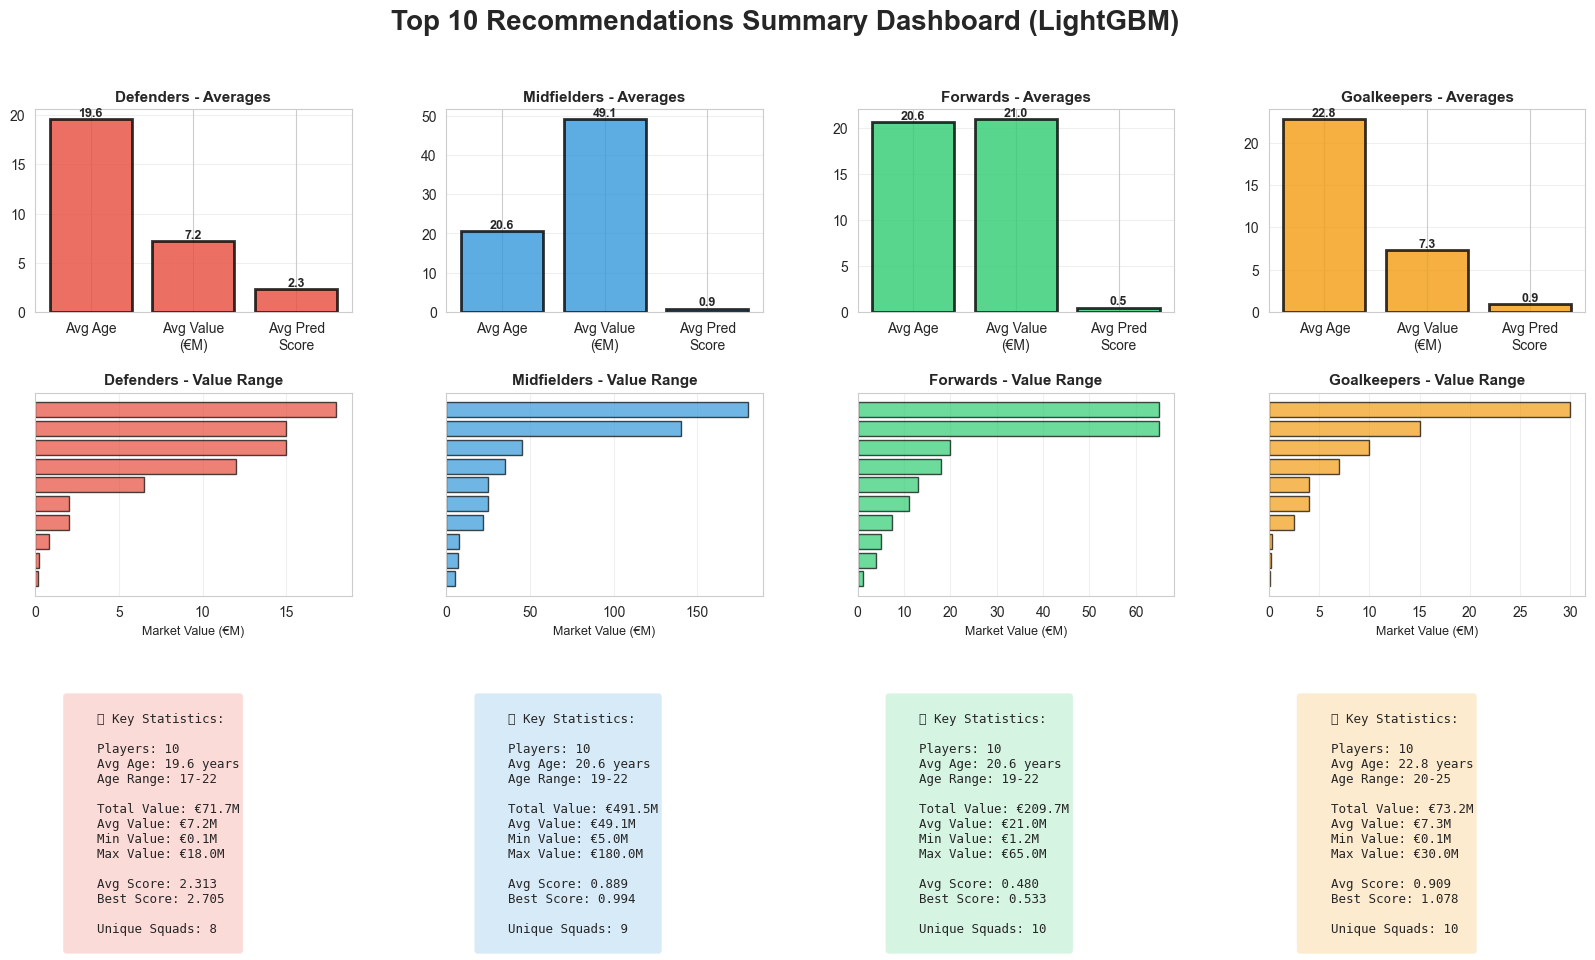

In [20]:
# 8. Summary Statistics Dashboard
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(3, 4, hspace=0.4, wspace=0.3)

fig.suptitle('Top 10 Recommendations Summary Dashboard (LightGBM)', fontsize=20, fontweight='bold', y=0.98)

for idx, position in enumerate(['Defender', 'Midfielder', 'Forward', 'Goalkeeper']):
    top10 = recommendations[position]['LightGBM']
    
    # Row 1: Average metrics bar chart
    ax1 = fig.add_subplot(gs[0, idx])
    metrics = {
        'Avg Age': top10['Age'].mean(),
        'Avg Value\n(€M)': top10['Market_Value'].mean() / 1e6,
        'Avg Pred\nScore': top10['Predicted_Score'].mean()
    }
    bars = ax1.bar(metrics.keys(), metrics.values(), color=colors_dict[position], alpha=0.8, edgecolor='black', linewidth=2)
    ax1.set_title(f'{position}s - Averages', fontsize=11, fontweight='bold')
    ax1.grid(axis='y', alpha=0.3)
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
    
    # Row 2: Market value range
    ax2 = fig.add_subplot(gs[1, idx])
    values_sorted = top10['Market_Value'].sort_values() / 1e6
    ax2.barh(range(len(values_sorted)), values_sorted, color=colors_dict[position], alpha=0.7, edgecolor='black')
    ax2.set_xlabel('Market Value (€M)', fontsize=9)
    ax2.set_title(f'{position}s - Value Range', fontsize=11, fontweight='bold')
    ax2.set_yticks([])
    ax2.grid(axis='x', alpha=0.3)
    
    # Row 3: Key stats text
    ax3 = fig.add_subplot(gs[2, idx])
    ax3.axis('off')
    
    stats_text = f"""
    📊 Key Statistics:
    
    Players: {len(top10)}
    Avg Age: {top10['Age'].mean():.1f} years
    Age Range: {top10['Age'].min():.0f}-{top10['Age'].max():.0f}
    
    Total Value: €{top10['Market_Value'].sum()/1e6:.1f}M
    Avg Value: €{top10['Market_Value'].mean()/1e6:.1f}M
    Min Value: €{top10['Market_Value'].min()/1e6:.1f}M
    Max Value: €{top10['Market_Value'].max()/1e6:.1f}M
    
    Avg Score: {top10['Predicted_Score'].mean():.3f}
    Best Score: {top10['Predicted_Score'].max():.3f}
    
    Unique Squads: {top10['Squad'].nunique()}
    """
    
    ax3.text(0.1, 0.9, stats_text, fontsize=9, family='monospace',
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor=colors_dict[position], alpha=0.2))

plt.tight_layout()
plt.show()